In [85]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [96]:
"""
The Time "t" is in hours
The Concentration "Ci" is in kg/m3
"""
Cx = pd.read_csv("../Literature/BioMassConc.csv", names=["t","Cx"], skiprows=1)   # biomass
Cs = pd.read_csv("../Literature/SubsConc.csv", names=["t","Cs"], skiprows=1)   # substrate
Co = pd.read_csv("../Literature/DOxygenConc.csv", names=["t","Co"], skiprows=1)   # dissolved O2
Cp = pd.read_csv("../Literature/ProductConc.csv", names=["t","Cp"], skiprows=1)   # product (PDO)

In [82]:
df = pd.read_csv("../Literature/BioMassConc.csv", names=["t","Cx"], skiprows=1)   # biomass

In [66]:
Cp['t']

0      0.882353
1      2.195652
2      3.620205
3      5.373402
4      7.672634
5     10.297954
6     12.374680
7     15.326087
8     17.727621
9     20.019182
10    22.742967
11    24.272379
12    27.103581
13    29.823529
14    31.785166
Name: t, dtype: float64

In [67]:
t = np.linspace(0, 35, 100)  # 0.1 h resolution

In [68]:
def interp_series(df, col):
    f = interp1d(df['t'], df[col], bounds_error=False, fill_value="extrapolate")
    return f(t)

Cx = interp_series(Cx, 'Cx')
Cs = interp_series(Cs, 'Cs')
Co = interp_series(Co, 'Co')
Cp = interp_series(Cp, 'Cp')

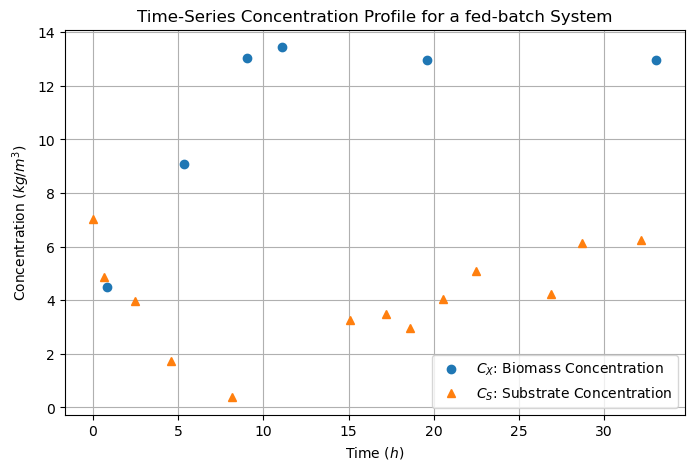

In [100]:
plt.figure(figsize=(8,5))
plt.plot(Cx["t"],Cx["Cx"],'o', label='$C_X$: Biomass Concentration') 
plt.plot(Cs["t"],Cs["Cs"],'^', label='$C_S$: Substrate Concentration') 
plt.xlabel("Time ($h$)")
plt.ylabel("Concentration ($kg/m^3$)")
plt.grid(True)
plt.legend()
plt.title("Time-Series Concentration Profile for a fed-batch System")
plt.show()

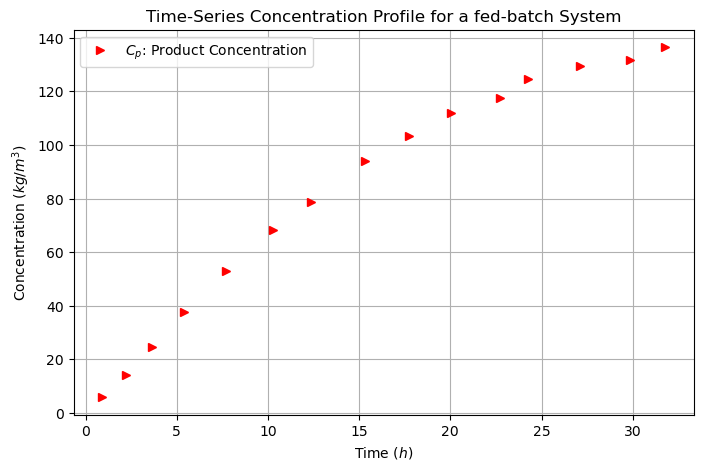

In [109]:
plt.figure(figsize=(8,5))
plt.plot(Cp["t"],Cp["Cp"],">",color="red", label='$C_p$: Product Concentration') 
plt.xlabel("Time ($h$)")
plt.ylabel("Concentration ($kg/m^3$)")
plt.grid(True)
plt.legend()
plt.title("Time-Series Concentration Profile for a fed-batch System")
plt.show()

In [70]:
# compute derivatives and instantaneous specific rates (finite differences)

dt = np.gradient(t)  # time step array (h)
dCxdt = np.gradient(Cx, t)
dCsdt = np.gradient(Cs, t)
dCpdt = np.gradient(Cp, t)
dCodt = np.gradient(Co, t)

# avoid division by zero
eps = 1e-12
rp_inst = dCpdt / (Cx + eps)        # specific product formation rate (1/h)
rs_inst = -dCsdt / (Cx + eps)       # specific substrate uptake (mass substrate / (mass biomass * h))
mu_inst = dCxdt / (Cx + eps)        # instantaneous specific growth rate (1/h)

# quick check print
print("sample mu_inst (first 5):", mu_inst[:5])
print("sample rp_inst (first 5):", rp_inst[:5])


sample mu_inst (first 5): [0.27483655 0.25049713 0.23011798 0.21280524 0.19791525]
sample rp_inst (first 5): [1.7045278  1.55357552 1.42718463 1.31981157 1.2274643 ]


In [77]:
def mu_model(cs, co, cp, params):
    mu_max, Ks, Ko, Kp = params
    term_s = cs / (cs + Ks + 1e-12)
    term_o = co / (co + Ko + 1e-12)
    term_p = np.maximum(0.0, (1 - cp / (Kp + 1e-12)))
    return mu_max * term_s * term_o * term_p

def simulate_Cx(t, mu_max, Ks, Ko, Kp):
    C0 = Cx[0]
    params = [mu_max, Ks, Ko, Kp]

    def rhs(C, tt):
        cs = np.interp(tt, t, Cs)
        co = np.interp(tt, t, Co)
        cp = np.interp(tt, t, Cp)
        mu = mu_model(cs, co, cp, params)
        return mu * C

    Csim = odeint(lambda C, tt: rhs(C, tt), C0, t).flatten()
    return Csim

# initial guesses and bounds
p0 = [4, 5, 1, 20.0]
bounds = ([1e-6, 1e-6, 1e-6, 1e-6], [5.0, 1e3, 1.0, 1e5])

# fit model to experimental biomass data
popt, pcov = curve_fit(simulate_Cx, t, Cx, p0=p0, bounds=bounds, maxfev=2000)
mu_max, Ks, Ko, Kp = popt
print(f"Fitted parameters:\nμmax={mu_max:.4f}, Ks={Ks:.4f}, Ko={Ko:.4f}, Kp={Kp:.4f}")




Fitted parameters:
μmax=3.9796, Ks=4.8920, Ko=0.9962, Kp=1227.2877


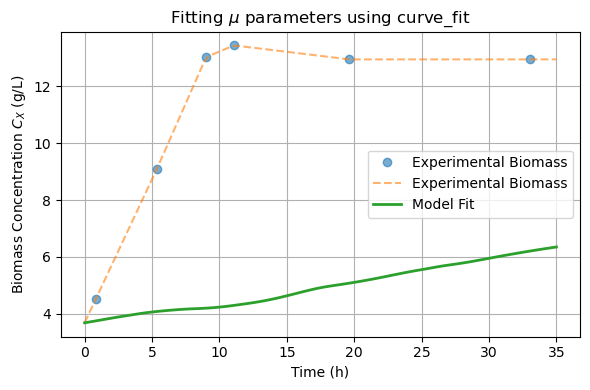

In [84]:
# simulate biomass with fitted parameters
Cx_fit = simulate_Cx(t, *popt)

# --- Plot result ---
plt.figure(figsize=(6,4))
plt.plot(df["t"], df["Cx"], 'o', label='Experimental Biomass', alpha=0.6)
plt.plot(t, Cx, '--', label='Experimental Biomass', alpha=0.6)
plt.plot(t, Cx_fit, '-', label='Model Fit', lw=2)
plt.grid()
plt.xlabel('Time (h)')
plt.ylabel('Biomass Concentration $C_X$ (g/L)')
plt.title('Fitting $\mu$ parameters using curve_fit')
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
dX_total = Cx[-1] - Cx[0]
dP_total = Cp[-1] - Cp[0]
dS_total = Cs[0] - Cs[-1]   # substrate consumed (positive)

Yxs_global = dX_total / dS_total if abs(dS_total) > 1e-12 else np.nan
Yps_global = dP_total / dS_total if abs(dS_total) > 1e-12 else np.nan
Ypx_global = dP_total / dX_total if abs(dX_total) > 1e-12 else np.nan

print("Global biomass yield Y_x/s =", Yxs_global)
print("Global product yield Y_p/s =", Yps_global)
print("Global product yield Y_p/X =", Ypx_global)


Global biomass yield Y_x/s = 13.457557971498511
Global product yield Y_p/s = 208.7631525332611
Global product yield Y_p/X = 15.512706909782318


In [81]:
y = np.asarray(Cx)
yhat = np.asarray(Cx_fit)

n = len(y)
p = len(popt)

sse = np.sum((y - yhat)**2)
mse = sse / n
rmse = np.sqrt(mse)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - sse / ss_tot if ss_tot > 0 else np.nan
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan

print(f"SSE = {sse:.4g}")
print(f"MSE = {mse:.4g}, RMSE = {rmse:.4g}")
print(f"R^2 = {r2:.4g}, Adjusted R^2 = {adj_r2:.4g}")


SSE = 5160
MSE = 51.6, RMSE = 7.183
R^2 = -6.921, Adjusted R^2 = -7.254
